# Chirps #

Create orthogonal chirps, run them through to the device, receive information from left and right speaker, and create correlations between original chirp and output data to determine distance.

In [1]:
import serial
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from numpy.fft import fft
import sounddevice as sd
import time

### Variable Definitions ###

In [2]:
#Definitions
sampling_f = 96e3 #kHz, min sampling frequency should be 0.7MHz
T_c = 10e-3 #chirp duration, s
#t = np.arange(0,T_c,1/sampling_f) #time, between 0 and T_c with steps of whatever 100khz (sample at 100kHz) is
f_s = 18e3 #starting frequency, Hz
f_h = 20e3 #ending frequency, Hz
phi = 0 #initial phase
B = f_h - f_s #bandwidth
mu = B / T_c #chirp rate
BUFFER_SIZE = 4096 #buffer size
samplef = 19e6 / 32 / 6
t = np.linspace(0,BUFFER_SIZE/samplef,BUFFER_SIZE)

#For calculating distance
speed = 343 #m/s
delay = 0.010552083333333333 #Computer delay found using sd.query_devices(kind='output')


### Function Definitions ###

In [3]:
#FIX THIS FUNCTION!!
def zero_pad(S_n,M):
    zeros = np.zeros(len(S_n))
    S_n1 = np.vstack((S_n,zeros, zeros)).T.flatten()
    S_n2 = np.vstack((zeros,S_n,zeros)).T.flatten()
    S_n3 = np.vstack((zeros,zeros,S_n)).T.flatten()
    #plt.plot(S_n1)
    #plt.plot(S_n2)
    #plt.plot(S_n3)
    #plt.xlim(550, 600)
    return(S_n1,S_n2,S_n3)

In [4]:
#Play Audio
sd.default.samplerate = sampling_f

def play_audio(data,fs , dev=None):
    sd.play(data)

In [5]:
#Function to plot chirps
def plotsound(x,y,a):
    plt.plot(x,y)
    plt.plot(x,a)
    plt.title("Linear Chirp")
    plt.xlabel("Time")
    #plt.ylabel("Amplitude") idk what label should be here

In [6]:
# Main function to initiate chirp signal, process it, and plot it
def audioprocessing(chirp):
    #Definition of arrays
    left = np.zeros(BUFFER_SIZE)
    right = np.zeros(BUFFER_SIZE)
    sample = np.arange(0,BUFFER_SIZE,1)
    time = np.linspace(0,BUFFER_SIZE/samplef,BUFFER_SIZE)

    #print("time2", time2.shape)
    #time = np.linspace(0,sampling_f / 42 / 6,BUFFER_SIZE)
    #time2 = np.linspace(0, 19e6 / 32 / 6 ,BUFFER_SIZE)

    # Write character to SiLabs to begin recording
    sound = True
    #time.sleep(delay)
    s.write(b'r')

    # Play chirp
    play_audio(np.imag(chirp),sampling_f) #Initial chirp
    #play_audio(np.imag(timesz),sampling_f) #Zero padded chirp
    
    while sound:
        
        read = s.readline()
        #print(read)

        try:
            read = read.decode().strip()
        except (UnicodeDecodeError, AttributeError):
            print("Error detected")
            pass

        #Store valeus into left array
        if read == "left":
            #print("Left array:\n")
            for i in range(0,BUFFER_SIZE-1):
                lineL = s.readline().decode().strip()
                if lineL != "right":
                    left[i] = lineL

        #Store values into right array            
        elif read == "right":
            #print("Right array:\n")
            for i in range(0,BUFFER_SIZE-1):
                lineR = s.readline().decode().strip()
                if lineR != "done":
                    right[i] = lineR

        #End sound recording and plot 
        elif read == "done":
            sound = False
            plotsound(time,left,right)
            
    return(left,right)

In [7]:
# Determines the time correlation between two functions
def t_correlation(s1,s2):
    FS_n1 = fft(s1)
    FS_n2 = fft(s2)
    
    TiS_n1 = np.fft.ifft(FS_n1)
    TiS_n2 = np.fft.ifft(FS_n2)
    
    Tcorr = np.correlate(TiS_n1,TiS_n2,"full")
    
    n = np.linspace(0, BUFFER_SIZE/samplef,len(Tcorr))
    
    fig, ax = plt.subplots()
    ax.plot(n,Tcorr)
    plt.title("Time Correlation")
    plt.xlabel("Time (s)")
    
    return(Tcorr,n)

In [8]:
#CALCULATING DISTANCE#
def distance(timecorrelation):
    t_est = n[np.argmax(timecorrelation)] - delay
    print("Estimated time:",t_est,"seconds")

    dist_est = t_est * speed
    print("Estimated distance:",dist_est,"meters")

## Start of main function ##

In [9]:
#Initial Chirp Function Definition
s_t = np.exp(2j * np.pi * (f_s * t + 1/2 * mu * np.square(t)) + phi)

#Plotting chirp
#plt.plot(t,s_t)
#plt.xlim(0,0.01)
#plt.ylim(-1,1)

#Create zero padded chirp to send in
sn = fft(s_t)
sz,extra1,extra2 = zero_pad(sn,2)
timesz = np.fft.ifft(sz)
time2z = np.fft.ifft(extra1)
time3z = np.fft.ifft(extra2)

### Print Serial Code ###

Initializes recording to play a chirp. A chirp plays, and data is processed and graphed to show a plot of the chirp.

Connected to serial port


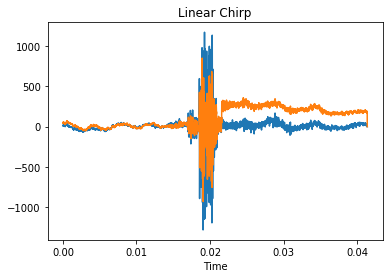

In [10]:
#Connect to serial port
s = serial.Serial('/dev/tty.usbmodem0004401714771')
print("Connected to serial port")

#MOST IMPORTANT LINE OF CODE!!!
chirp1 = s_t #Sets what you want chirp to be
#chirp2 = time2z
#chirp3 = time3z
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

left1, right1 = audioprocessing(chirp1) #Runs function
#left2, right2 = audioprocessing(chirp2)
#left3, right3 = audioprocessing(chirp3)
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
#ax1.plot(t,right1)
#ax1.plot(t,left1)
#ax2.plot(t,right2)
#ax2.plot(t,left2)
#ax3.plot(t,right3)
#ax3.plot(t,left3)
#print(left,right)

### Correlation ###

In [11]:
#Close serial port
s.flushInput()
s.flushOutput()
s.close()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


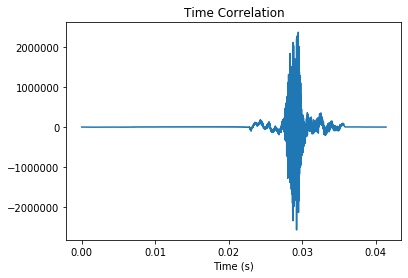

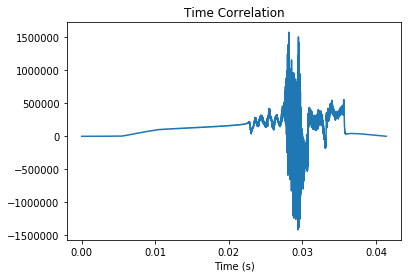

In [13]:
tcorrL = t_correlation(left1,sz)
tcorrR = t_correlation(right1,sz)

In [ ]:
#Calculate correlation between two values

#tcorr = t_correlation(left,sz)
tacorrorleft1,n = t_correlation(left1,chirp1)
tacorrorright1,n = t_correlation(right1,chirp1)

tacorrorleft2,n = t_correlation(left2,chirp2)
tacorrorright2,n = t_correlation(right2,chirp2)

tacorrorleft3,n = t_correlation(left3,chirp3)
tacorrorright3,n = t_correlation(right3,chirp3)

tcorrorleft12,n = t_correlation(left1,left2)
#tcorrorright12,n = t_correlation(right1,right2)

tcorrorleft13,n = t_correlation(left1,left3)
#tcorrorright13,n = t_correlation(right1,right3)

tcorrorleft23,n = t_correlation(left2,left3)
#tcorrorright23,n = t_correlation(right2,right3)

#Average between correlations
#avg = (tcorrorleft+tcorrorright) / 2
#plt.plot(n,avg, alpha = 0.5)

In [ ]:
#Prints distance and estimated time
distance(avg)

### Below is just trial and error code which will be deleted soon ###

In [ ]:
#FFT to frequency domain
S_nL = fft(left)
S_nR = fft(right)
sn = fft(s_t) #initial chirp

#IFFT to time domain
time_iS_nL = np.fft.ifft(S_nL)
time_iS_nR = np.fft.ifft(S_nR)
tisn = np.fft.ifft(sn) #inital chirp

#Correlations between left/right and the initial chirp
TIME_correlationL = np.correlate(time_iS_nL,tisn,"full")
TIME_correlationR = np.correlate(time_iS_nR,tisn,"full")

#New time array for graphing... need to look at because units are wrong
n = np.linspace(0, BUFFER_SIZE/samplef,len(TIME_correlationL))

#Average between correlations
avg = (TIME_correlationL+TIME_correlationR) / 2
#Plotting each correlation
plt.plot(n,TIME_correlationL, color="red")
plt.plot(n,TIME_correlationR, color="blue")
plt.plot(n,avg, color ="orange", alpha = 0.5)
plt.title("Correlation of Left and Right Signals with Initial Signal")
plt.xlabel("Time (s)")

In [ ]:
#Zero Padding Correlations
S_nLZ,S_nL2,S_nL3 = zero_pad(S_nL,3)
S_nZ,S_n2,S_n3 = zero_pad(sn,3)

time_iLZ = np.fft.ifft(S_nLZ)
time_iZ = np.fft.ifft(S_nZ)

TIME_correlationZ = np.correlate(time_iLZ,time_iZ,"full")
nZ = np.linspace(0, BUFFER_SIZE/samplef,len(TIME_correlationZ))
plt.plot(nZ,TIME_correlationZ, color="green")
plt.title("Correlation of Left Signal With Initial: Zero Padded (2 zeroes)")
plt.xlabel("time (seconds)")


In [ ]:
#send zero padded orthogonal chirps 
#change frequency range to increase distance of collectin chirps